<a href="https://colab.research.google.com/github/JaganFoundr/PyTorchNN/blob/main/Deeplearningwithgpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#LINEAR REGRESSION

#importing all the important libraries
import torch
import numpy as np

#inputs (temperature, rainfall, humidity)
inputs=np.array([[73,67,45],
                 [91,88,64],
                 [87,134,58],
                 [102,43,37],
                 [69,96,70]],dtype='float32')

#targets (apples, oranges)
targets=np.array([[56,70],
                 [81,101],
                 [119,133],
                 [22,37],
                 [103,119]],dtype='float32')

#converting inputs and targets from numpy format to tensor format
inputs=torch.from_numpy(inputs)
targets=torch.from_numpy(targets)

# defining random weights and biases
weights=torch.randn(2,3,requires_grad=True)
bias=torch.randn(2,requires_grad=True)

#function for the prediction equation for the model
def model(x):
  return x @ weights.t()+bias

#function for the loss
def mse(x,y):
  diff=x-y
  return torch.sum(diff*diff)/diff.numel()

#training loop with 1000 epochs
for i in range(1000):

  #predicting using the inputs
  prediction=model(inputs)

  # checking the loss of the prediction
  loss=mse(prediction, targets)
  print(loss)

  # backpropogating to compute gradients and update the weights
  loss.backward()

  #updating the weights without tracking the gradient
  with torch.no_grad():

    #learning rate value
    lr=0.00001

    #updating weights
    weights-=weights.grad*lr

    #updating bias
    bias-=bias.grad*lr

    #emptying the gradients of weights and bias
    weights.grad.zero_()
    bias.grad.zero_()

print(loss)

In [ ]:
#MORE COMPLEX LINEAR REGRESSION

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
import numpy as np


inputs=np.array([[73,67,43],[91,88,64],[87,134,58],
                 [102,43,37],[69,96,70],[73,67,43],
                 [91,88,64],[87,134,58],[102,43,37],
                 [69,96,70],[73,67,43],[91,88,64],
                 [87,134,58],[102,43,37],[69,96,70]],dtype='float32')

targets=np.array([[56,70],[81,101],[119,133],
                 [22,37],[103,119],[56,70],
                 [81,101],[119,133],[22,37],
                 [103,119],[56,70],[81,101],
                 [119,133],[22,73],[103,119]],dtype='float32')

inputs=torch.tensor(inputs)
targets=torch.tensor(targets)

training_data=TensorDataset(inputs,targets)

batch_size = 5

training_data=DataLoader(training_data, batch_size, shuffle=True )

model=nn.Linear(3,2)

list(model.parameters())

loss_fn = F.mse_loss

optimizer=torch.optim.SGD(model.parameters(),lr=0.00001)

def train_function(nepochs, model, loss_fn, optimizer):
  for epochs in range(nepochs):
    for x,y in training_data:

      prediction = model(x)

      loss = loss_fn(prediction, y)

      loss.backward()

      optimizer.step()

      optimizer.zero_grad()

    if (epochs+1)%10==0:
      print(f"epochs: {epochs+1}/{nepochs} , loss: {loss.item()}")

train_function(1000, model, loss_fn, optimizer)

prediction=model(inputs)

print(prediction)

print(targets)

In [ ]:
#LOGISTIC REGRESSION USING MNIST

#importing libraries
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader

#main dataset and testdata
dataset=MNIST(download=True, train=True, root="./data", transform=transforms.ToTensor())
testset=MNIST(root="./data", train=False, transform=transforms.ToTensor())

#plotting the dataset
image,labels=dataset[1000]
plt.imshow(image[0,10:25,10:25], cmap="gray")
plt.show()
print("label: ", labels)

In [ ]:
#splitting the whole dataset into validation data and training data
def split_data(dataset, validation_percent):
  validation_data=int(dataset*validation_percent)
  shuffled=np.random.permutation(dataset)
  return shuffled[validation_data:], shuffled[:validation_data]

training_data,validation_data = split_data(len(dataset), 0.3)
print("length of training data: ", len(training_data))
print("length of validation data: ", len(validation_data))

print("portion of validation data: ",validation_data[:20])

In [ ]:
#putting all the splitted data to the sampler and then into the dataloader
train_data_sampler=SubsetRandomSampler(training_data)
valid_data_sampler=SubsetRandomSampler(validation_data)

batch_size=100

training_loader=DataLoader(dataset, batch_size, sampler=train_data_sampler)
validation_loader=DataLoader(dataset, batch_size, sampler=valid_data_sampler)

In [ ]:
#defining the model
input_size=28*28
num_classes=10

class MNISTmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.Linear=nn.Linear(input_size,num_classes)

  def forward(self, size):
    size=size.reshape(-1,784)
    output=self.Linear(size)
    return output

model=MNISTmodel()

In [ ]:
#putting the training loader in the for loop as inputs and outputs for prediction
for images, labels in training_loader:
  prediction=model(images)

In [ ]:
#display predictions and sum of the predictions of each array
print(prediction[:2])
sum=torch.sum(prediction[2])
print(sum)

#changing the sum of the probablities of the predictions close to 1 and then checking the sum again
prob=F.softmax(prediction)
print(prob[:2])
sum=torch.sum(prob[2])
print(sum)

#displaying the exact predicted labels by the model
max_prob, pred = torch.max(prob, dim=1)
print(pred)
print(max_prob)

#displaying the actual target labels
print(labels)

In [ ]:
#defining the loss
loss_fn=F.cross_entropy

In [ ]:
#defining the optimizer
opt=torch.optim.SGD(model.parameters(), lr=0.0001)

In [ ]:
# accuracy metrics
def accuracy(outputs, labels):
  _,pred=torch.max(outputs, dim=1)
  return (torch.sum(pred==labels).item()/len(pred))*100

In [ ]:
# loss batch function for loss computation, gradient computation, updating weights, resetting gradients, accuracy computation
def loss_batch(model, loss_fn, images, labels, opt, metrics=accuracy):
  prediction=model(images)
  loss=loss_fn(prediction, labels)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result=None
  if metrics is not None:
    metric_result=metrics(prediction, labels)

  return loss.item(), len(images), metric_result

In [ ]:
# function for evaluating the average loss and average accuracy of the validation set
def evaluate(model, loss_fn, validation_loader, metrics=accuracy):
  with torch.no_grad():
    validation_prediction=[loss_batch(model, loss_fn, images, labels, opt=None, metrics=accuracy) for images, labels in validation_loader]

    losses, nums, metric=zip(*validation_prediction)

    total=np.sum(nums)

    average_loss = np.sum(np.multiply(losses, nums))/total

    average_metrics=None
    if metrics is not None:
      average_metrics = np.sum(np.multiply(metric, nums))/total

  return average_loss.item(), total, average_metrics

In [ ]:
#function for explicit training
def fit(nepochs, model, images, labels, training_loader, validation_loader, opt, metrics=accuracy):
  for epoch in range(nepochs):
    for images, labels in training_loader:
      train_loss,_, train_accuracy=loss_batch(model, loss_fn, images, labels, opt, metrics=accuracy)

    valid_loss, _, valid_accuracy= evaluate(model, loss_fn, validation_loader, metrics=accuracy)

    print(f"Epoch: {epoch+1}/{nepochs}")
    print(f"Training loss: {train_loss:.4f} and Validation loss: {valid_loss:.4f}.")
    print(f"Training accuracy: {train_accuracy:.2f}% and Validation accuracy: {valid_accuracy:.2f}%.")
    print("--------------------------------------------------------------------------------------------")

  return train_loss, _, train_accuracy, valid_loss, _, valid_accuracy

train_loss,_, train_accuracy, valid_loss, _, valid_accuracy = fit(6, model, images, labels, training_loader, validation_loader, opt, metrics=accuracy)

print("--")
print(f"The train accuracy is {train_accuracy:.2f} % and loss is {train_loss:.4f}.")
print("--------------------------------------------")
print(f"The validation accuracy is {valid_accuracy:.2f} % and loss is {valid_loss:.4f}")

In [ ]:
# testing the model with the testing dataset
#function for predicting the test images
def predict_image(image, model):
  input=image.unsqueeze(0)
  output=model(input)
  _,preds=torch.max(output, dim=1)

  return preds[0].item()

In [ ]:
#predicting and displaying different labels
image,labels=testset[10]
plt.imshow(image[0], cmap="gray")
plt.show()
print("label: ", labels)
print("predicted: ", predict_image(image, model))

image,labels=testset[100]
plt.imshow(image[0], cmap="gray")
plt.show()
print("label: ", labels)
print("predicted: ", predict_image(image, model))

image,labels=testset[1000]
plt.imshow(image[0], cmap="gray")
plt.show()
print("label: ", labels)
print("predicted: ", predict_image(image, model))

image,labels=testset[905]
plt.imshow(image[0], cmap="gray")
plt.show()
print("label: ", labels)
print("predicted: ", predict_image(image, model))

In [ ]:
#checking the loss and accuracy on the test set
test_loader=DataLoader(testset, batch_size=200)
test_loss, total, test_accuracy=evaluate(model, loss_fn, test_loader, metrics=accuracy)
print(f"The test set loss is {test_loss:.4f} and the accuracy is {test_accuracy:.2f}%.")

In [ ]:
#saving and loading the model
torch.save(model.state_dict(),'MNISTlogistic.pth')
model.state_dict()

In [ ]:
savedmodel=MNISTmodel()
savedmodel.load_state_dict(torch.load('MNISTlogistic.pth'))
savedmodel.state_dict()

In [13]:
#1
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

In [14]:
#2
dataset=MNIST(root='./data', download=True, train=True, transform=transform.ToTensor())
testset=MNIST(root='./data', download=True, train=False, transform=transform.ToTensor())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

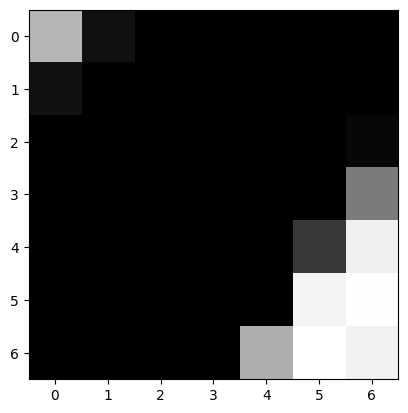

labels:  7


In [16]:
#3
images, labels = dataset[230]
plot=images[:,10:17,10:17]
plt.imshow(plot[0], cmap='gray')
plt.show()
print("labels: ",labels)

In [17]:
#4
def splitted_data(data, valid_data_percent):
  valid_num=int(data*valid_data_percent)
  index=np.random.permutation(data)
  return index[valid_num:], index[:valid_num]
training_data, validation_data=splitted_data(len(dataset), 0.25)
print("Training data: ",len(training_data))
print("Validation data",len(validation_data))
print("portion of validation data: ", validation_data[:20])

Training data:  45000
Validation data 15000
portion of validation data:  [33785 57614 26916 15407 24403 56920 12757 21044 37272 21664 15867 10383
 17940  4566 12815 35714 13302 40611  3304 52190]


In [26]:
#5
training_sampler=SubsetRandomSampler(training_data)
validation_sampler=SubsetRandomSampler(validation_data)

batch_size=100

training_loader=DataLoader(dataset=dataset, batch_size=batch_size, sampler=training_sampler)
validation_loader=DataLoader(dataset=dataset, batch_size=batch_size, sampler=validation_sampler)

In [19]:
#6
input_size=28*28
hidden_size1=256
hidden_size2=128
output_size=10
class MNISTMODEL(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2 ,output_size):
    super().__init__()
    #hidden layer1
    self.linear1=nn.Linear(input_size, hidden_size1)
    #hidden layer2
    self.linear2=nn.Linear(hidden_size1, hidden_size2)
    #output layer
    self.linear3=nn.Linear(hidden_size2, output_size)


  def forward(self,batch):
    size=batch.view(batch.size(0),-1)

    hidden1=self.linear1(size)

    output=F.relu(hidden1)

    hidden2=self.linear2(output)

    output=F.relu(hidden2)

    output=self.linear3(output)

    return output

model=MNISTMODEL(input_size, hidden_size1, hidden_size2, output_size).to(device)

In [105]:
for t in model.parameters():
  print(t.shape)
  print(t.device)

torch.Size([256, 784])
cuda:0
torch.Size([256])
cuda:0
torch.Size([128, 256])
cuda:0
torch.Size([128])
cuda:0
torch.Size([10, 128])
cuda:0
torch.Size([10])
cuda:0


In [98]:
#7
for images, labels in training_loader:
  images, labels = images.to(device), labels.to(device)
  prediction=model(images)

In [43]:
#8
print(prediction[0])

#9
prob_sum=torch.sum(prediction[0])
print(prob_sum)

changed_pred=F.softmax(prediction)
changed_sum=torch.sum(changed_pred[9])
print(changed_sum)

tensor([ 5.1349, -4.3022,  0.5593, -0.0089, -2.1328,  2.4256,  1.2476, -3.1976,
         0.7817, -2.8177], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-2.3101, device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


<ipython-input-43-a0f466636ccd>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  changed_pred=F.softmax(prediction)


In [44]:
#10
_,pred=torch.max(prediction, dim=1)
print(pred)

tensor([0, 4, 3, 1, 7, 5, 1, 8, 6, 9, 8, 3, 9, 3, 1, 7, 3, 6, 0, 2, 3, 5, 5, 9,
        9, 9, 2, 5, 1, 8, 4, 5, 9, 7, 3, 7, 9, 1, 4, 4, 5, 5, 5, 2, 0, 3, 0, 0,
        0, 7, 0, 7, 1, 1, 2, 3, 7, 1, 2, 1, 1, 6, 5, 4, 8, 2, 4, 1, 0, 3, 6, 9,
        1, 1, 0, 0, 6, 1, 1, 9, 6, 3, 8, 0, 6, 6, 4, 3, 9, 6, 2, 7, 9, 1, 1, 1,
        2, 2, 6, 5], device='cuda:0')


In [45]:
#11
labels

tensor([0, 4, 3, 1, 7, 5, 1, 5, 6, 9, 8, 3, 9, 3, 1, 7, 3, 6, 0, 2, 5, 5, 5, 4,
        9, 9, 2, 5, 1, 3, 4, 5, 9, 3, 8, 7, 9, 1, 9, 4, 5, 5, 5, 2, 0, 3, 0, 0,
        0, 7, 0, 7, 1, 1, 2, 3, 7, 7, 2, 1, 5, 6, 3, 9, 8, 2, 4, 1, 0, 3, 0, 8,
        2, 1, 0, 0, 6, 8, 7, 7, 4, 3, 8, 0, 5, 0, 4, 8, 9, 6, 2, 2, 9, 1, 8, 8,
        2, 2, 6, 5], device='cuda:0')

In [31]:
#12
def accuracy(output, labels):
  _,pred=torch.max(output, dim=1)
  return torch.sum(pred==labels).item()/len(pred)*100

In [48]:
#13
loss_function=F.cross_entropy

In [33]:
#14
opt=torch.optim.SGD(model.parameters(), lr=0.01)

In [101]:
#15
def loss_batch(model, loss_function, images, labels, opt, metrics=accuracy):
  prediction=model(images.to(device))
  loss=loss_function(prediction, labels.to(device))

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result=None
  if metrics is not None:
    metric_result=metrics(prediction, labels.to(device))

  return loss.item(), len(images), metric_result

device(type='cuda', index=0)

In [104]:
#16
def evaluate(model, loss_function, validation_loader, metrics=accuracy):
  with torch.no_grad():
    result=[loss_batch(model, loss_function, images.to(device), labels.to(device), opt=None, metrics=accuracy) for images, labels in validation_loader]

    losses, num, metric=zip(*result)

    total=np.sum(num)

    loss=np.sum(np.multiply(losses, num))/total

    if metrics is not None:
      metric=np.sum(np.multiply(metric, num))/total
  return loss, total, metric

In [86]:
#17
def train(nepochs, model, loss_function, training_loader, validation_loader, images, labels, opt, metrics=accuracy):
  for epoch in range(nepochs):
    for images, labels in training_loader:

      images, labels = images.to(device), labels.to(device)

      train_loss,_,train_acc=loss_batch(model, loss_function, images.to(device), labels.to(device), opt, metrics=accuracy)

    valid_loss,_,valid_acc=evaluate(model, loss_function, validation_loader, metrics=accuracy)

    print(f"Epoch: {epoch+1}/{nepochs}")
    print(f"Training loss: {train_loss:.4f} and Validation loss: {valid_loss:.4f}.")
    print(f"Training accuracy: {train_acc:.2f}% and Validation accuracy: {valid_acc:.2f}%.")
    print("--------------------------------------------------------------------------------------------")

  return train_loss,train_acc, valid_loss,valid_acc

train_loss, train_acc, valid_loss, valid_acc = train(1, model, loss_function, training_loader, validation_loader, images, labels, opt, metrics=accuracy)



Epoch: 1/1
Training loss: 0.2371 and Validation loss: 0.2243.
Training accuracy: 95.00% and Validation accuracy: 93.61%.
--------------------------------------------------------------------------------------------


In [87]:
#18
def prediction(images, model):
  input=images.to(device).unsqueeze(0)
  output=model(input)
  _,pred=torch.max(output, dim=1)

  return pred[0].item()

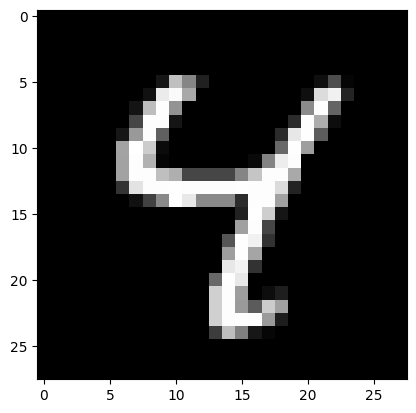

labels:  4
predicted:  4
(0.21343292355537413, 10000, 93.78)


In [96]:
#19
images, labels=testset[6]
plt.imshow(images[0], cmap='gray')
plt.show()
print("labels: ", labels)
print("predicted: ",prediction(images.to(device), model))

test_loader=DataLoader(testset, batch_size=200)


#test accuracy (you define it in your own form)
print(evaluate(model, loss_function, test_loader, metrics=accuracy))



In [ ]:
#20
torch.save(model.state_dict(), "MNIST.pth")
model.state_dict()

In [30]:
saved_model=MNISTMODEL(input_size, hidden_size1, hidden_size2, output_size)
saved_model.load_state_dict(torch.load('MNIST.pth'))
saved_model.state_dict()

<ipython-input-30-450330895b00>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model.load_state_dict(torch.load('MNIST.pth'))


OrderedDict([('linear1.weight',
              tensor([[ 0.0309, -0.0147, -0.0004,  ..., -0.0085,  0.0245, -0.0021],
                      [-0.0130, -0.0012,  0.0206,  ..., -0.0162, -0.0222,  0.0155],
                      [ 0.0034, -0.0287, -0.0199,  ...,  0.0281,  0.0024, -0.0180],
                      ...,
                      [-0.0086, -0.0159, -0.0022,  ..., -0.0001,  0.0351, -0.0111],
                      [-0.0244, -0.0195,  0.0345,  ..., -0.0222, -0.0320,  0.0198],
                      [-0.0317, -0.0181,  0.0255,  ..., -0.0042, -0.0212,  0.0119]])),
             ('linear1.bias',
              tensor([ 3.1300e-02,  4.4668e-02,  1.5617e-02,  1.8764e-02,  7.5081e-02,
                       3.0093e-02, -1.8613e-02, -1.1791e-02, -4.8617e-03,  6.2139e-02,
                      -1.3675e-03,  5.0789e-02, -4.3445e-02, -4.8329e-04,  4.3572e-03,
                       2.2874e-02, -4.8038e-05, -8.8091e-03,  9.5547e-04,  1.8695e-02,
                       3.4536e-02,  3.1684e-02, -1.5120e